4.13

This question should be answered using the $\verb|Weekly|$ data set, which
 is part of the $\verb|ISLP|$ package. This data is similar in nature to the
 $\verb|Smarket|$ data from this chapter’s lab, except that it contains 1,089
 weekly returns for 21 years, from the beginning of 1990 to the end of
 2010.

In [73]:
from ISLP import load_data
import statsmodels.api as sm
from ISLP.models import (ModelSpec as MS,summarize)
import numpy as np
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
    (LinearDiscriminantAnalysis as LDA,
    QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


weekly = load_data('Weekly')
weekly

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up
...,...,...,...,...,...,...,...,...,...
1084,2010,-0.861,0.043,-2.173,3.599,0.015,3.205160,2.969,Up
1085,2010,2.969,-0.861,0.043,-2.173,3.599,4.242568,1.281,Up
1086,2010,1.281,2.969,-0.861,0.043,-2.173,4.835082,0.283,Up
1087,2010,0.283,1.281,2.969,-0.861,0.043,4.454044,1.034,Up


a.

Produce some numerical and graphical summaries of the Weekly
 data. Do there appear to be any patterns?

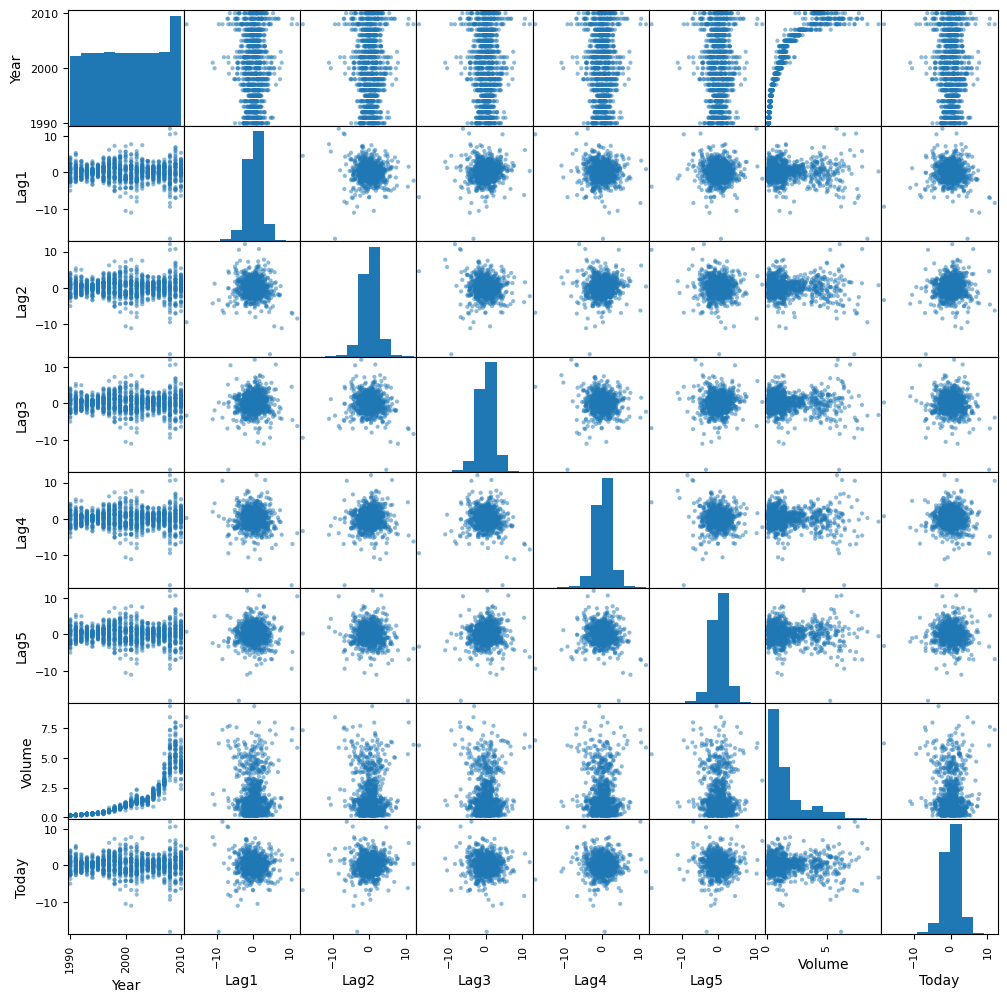

In [74]:
pd.plotting.scatter_matrix(weekly, alpha=0.5, figsize=(12,12))


allvar = list(weekly.columns)
df=MS(allvar).fit_transform(weekly)
Test=df.drop(columns='intercept')

#f = plt.figure(figsize=(19, 15))
#plt.matshow(Test, fignum=f.number)
#plt.xticks(range(Test.select_dtypes(['number']).shape[1]), Test.select_dtypes(['number']).columns, fontsize=14, rotation=45)
#plt.yticks(range(Test.select_dtypes(['number']).shape[1]), Test.select_dtypes(['number']).columns, fontsize=14)
#cb = plt.colorbar()
#cb.ax.tick_params(labelsize=14)
#plt.title('Correlation Matrix', fontsize=16)

<Axes: >

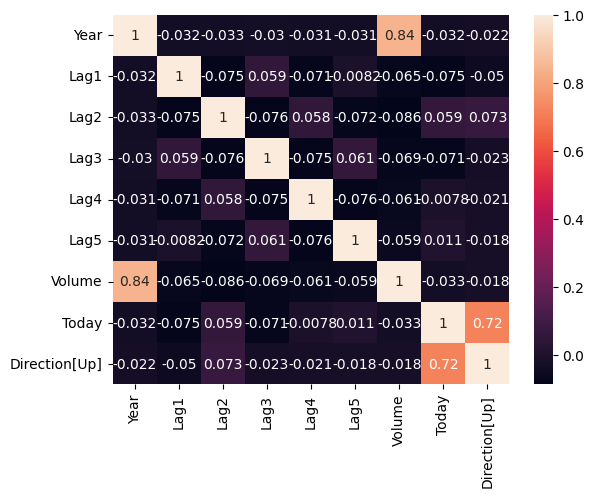

In [75]:
sns.heatmap(Test.corr(),annot=True)

<Axes: xlabel='Year'>

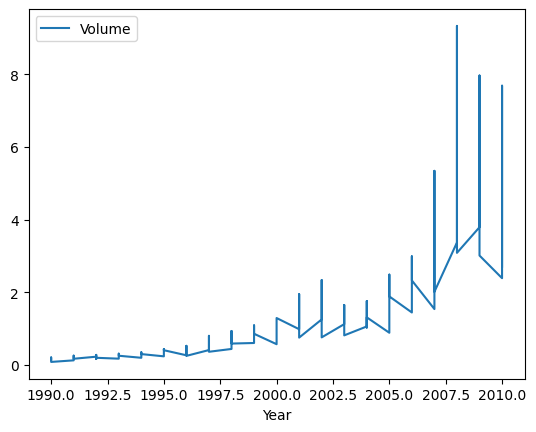

In [76]:
weekly.plot(x='Year',y='Volume')

<Axes: >

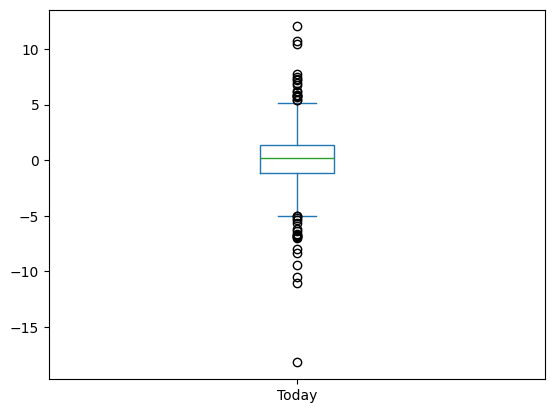

In [77]:
weekly.plot(y='Today',kind='box')

b.

Use the full data set to perform a logistic regression with
 Direction as the response and the five lag variables plus Volume
 as predictors. Use the summary function to print the results. Do
 any of the predictors appear to be statistically significant? If so,
 which ones?

In [78]:
weekly = weekly.dropna()
y = weekly.Direction == 'Up'
X = MS(['Lag1','Lag2', 'Lag3','Lag4','Lag5','Volume']).fit_transform(weekly)
y
model = sm.GLM(y,X,family=sm.families.Binomial())
result = model.fit()
summarize(result)

,coef,std err,z,P>|z|
intercept,0.2669,0.086,3.106,0.002
Lag1,-0.0413,0.026,-1.563,0.118
Lag2,0.0584,0.027,2.175,0.030
Lag3,-0.0161,0.027,-0.602,0.547
Lag4,-0.0278,0.026,-1.050,0.294
Lag5,-0.0145,0.026,-0.549,0.583
Volume,-0.0227,0.037,-0.616,0.538


We see one value that appears to be statistically significant and that is $\textit{Lag2}$

c.

Compute the confusion matrix and overall fraction of correct
 predictions. Explain what the confusion matrix is telling you
 about the types of mistakes made by logistic regression.

In [79]:
probs = result.predict()
probs[:10]

array([0.60862494, 0.60103144, 0.58756995, 0.48164156, 0.61690129,
       0.56841902, 0.57860971, 0.51519724, 0.57151998, 0.55542873])

In [80]:
from ISLP import confusion_table

label = np.array(['Down']*1089)
label[probs>0.5] = 'Up'

confusion_table(label, weekly.Direction)

Truth,Down,Up
Predicted,,
Down,54,48
Up,430,557


In [81]:
(54+557)/1089, np.mean(label == weekly.Direction)

(0.5610651974288338, 0.5610651974288338)

Here we can see that the model predicted the market return rate with $56%$ accuracy

d.

Now fit the logistic regression model using a training data period
 from 1990 to 2008, with Lag2 as the only predictor. Compute the
 confusion matrix and the overall fraction of correct predictions
 for the held out data (that is, the data from 2009 and 2010).

In [82]:
wshort = (weekly.Year<2009)
wshort
weekly_train = weekly.loc[wshort]
weekly_test = weekly.loc[~wshort]
X = MS(['Lag2']).fit_transform(weekly)

X_train, X_test = X.loc[wshort], X[~wshort]
y_train, y_test = y.loc[wshort], y[~wshort]
model = sm.GLM(y_train,X_train,family=sm.families.Binomial())
result = model.fit()
probs = result.predict(exog=X_test)
summarize(result)

,coef,std err,z,P>|z|
intercept,0.2033,0.064,3.162,0.002
Lag2,0.0581,0.029,2.024,0.043


In [83]:
D = weekly.Direction
L_train, L_test = D.loc[wshort], D.loc[~wshort]

labels = np.array(['Down']*104)
labels[probs>0.5] = 'Up'
confusion_table(labels,L_test)

Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [84]:
(9+56)/(61 + 43)

0.625

e. 

Repeat (d) using LDA

In [85]:
X_train, X_test = [M.drop(columns=['intercept'])
                  for M in [X_train, X_test]]

In [86]:
lda = LDA(store_covariance=True)
lda.fit(X_train, L_train)

lda_pred = lda.predict(X_test)
confusion_table(lda_pred,L_test)

Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [87]:
(65)/(65+39), np.mean(lda_pred == L_test)

(0.625, 0.625)

In [88]:
lda_pred

array(['Up', 'Up', 'Down', 'Down', 'Up', 'Up', 'Up', 'Down', 'Down',
       'Down', 'Down', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Down', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Down', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Down', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Down', 'Up',
       'Down', 'Up', 'Up', 'Up', 'Up', 'Down', 'Down', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Down', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up'],
      dtype='<U4')

f. 

Repeat (d) using QDA

In [89]:
qda = QDA(store_covariance=True)
qda.fit(X_train,L_train)

qda_pred = qda.predict(X_test)
confusion_table(qda_pred,L_test)

Truth,Down,Up
Predicted,,
Down,0,0
Up,43,61


In [90]:
np.mean(qda_pred == L_test)

0.5865384615384616

g.

Repeat (d) using KNN with $K=1$

In [91]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train,L_train)
knn_pred = knn.predict(X_test)
confusion_table(knn_pred,L_test)

Truth,Down,Up
Predicted,,
Down,22,31
Up,21,30


In [92]:
(30+22)/(30+22+31+21), np.mean(knn_pred == L_test)

(0.5, 0.5)

h.

Repeat (d) using naive Bayes

In [93]:
nb = GaussianNB()
nb.fit(X_train,L_train)

nb_pred = nb.predict(X_test)
confusion_table(nb_pred,L_test)

Truth,Down,Up
Predicted,,
Down,0,0
Up,43,61


In [94]:
np.mean(nb_pred == L_test)

0.5865384615384616

i.

Which of these methods appears to provide the best results on
 this data?

**Ans:**

It appears that the LDA model and logistic regression with the intercept are the best predictors that gove us $62.5%$ accuracy
_________________________________________________________________________________________________________________

j.

Experiment with different combinations of predictors, including possible transformations and interactions, for each of the methods. Report the variables, method, and associated confusion matrix that appears to provide the best results on the held out data. Note that you should also experiment with values for K in the KNN classifier.

**Ans:**

First with different K for KNN

$K=2$

In [95]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train,L_train)
knn_pred = knn.predict(X_test)
confusion_table(knn_pred,L_test)

Truth,Down,Up
Predicted,,
Down,31,43
Up,12,18


In [96]:
np.mean(knn_pred == L_test)

0.47115384615384615

$K=5$

In [97]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,L_train)
knn_pred = knn.predict(X_test)
confusion_table(knn_pred,L_test)

Truth,Down,Up
Predicted,,
Down,16,21
Up,27,40


In [98]:
np.mean(knn_pred == L_test)

0.5384615384615384

$K=10$

In [99]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train,L_train)
knn_pred = knn.predict(X_test)
confusion_table(knn_pred,L_test)

Truth,Down,Up
Predicted,,
Down,22,24
Up,21,37


In [100]:
np.mean(knn_pred == L_test)

0.5673076923076923

4.14

In this problem, you will develop a model to predict whether a given car gets high or low gas mileage based on the Auto data set.

In [101]:
from ISLP import load_data
import statsmodels.api as sm
from ISLP.models import (ModelSpec as MS,summarize)
import numpy as np
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
    (LinearDiscriminantAnalysis as LDA,
    QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Auto = load_data('Auto')
X = Auto['displacement']
X.shape

(392,)

a.

 Create a binary variable, mpg01, that contains a 1 if mpg contains
 a value above its median, and a 0 if mpg contains a value below
 its median. You can compute the median using the median()
 method of the data frame. Note you may find it helpful to add
 a column mpg01 to the data frame by assignment. Assuming you
 have stored the data frame as Auto, this can be done as follows.

In [102]:
mpg = Auto['mpg']
mpg01 = np.where(mpg < np.median(mpg),0,1)
Auto['mpg01'] = mpg01

b.

 Explore the data graphically in order to investigate the associ
ation between mpg01 and the other features. Which of the other
 features seem most likely to be useful in predicting mpg01? Scat
terplots and boxplots may be useful tools to answer this ques
tion. Describe your findings.

{'whiskers': [<matplotlib.lines.Line2D at 0x1cdd7ef92d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1cdd7ef98a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1cdd7ef9930>,
 'medians': [<matplotlib.lines.Line2D at 0x1cdd5051a20>,
 'fliers': [<matplotlib.lines.Line2D at 0x1cdd7ef8cd0>,
 'means': []}

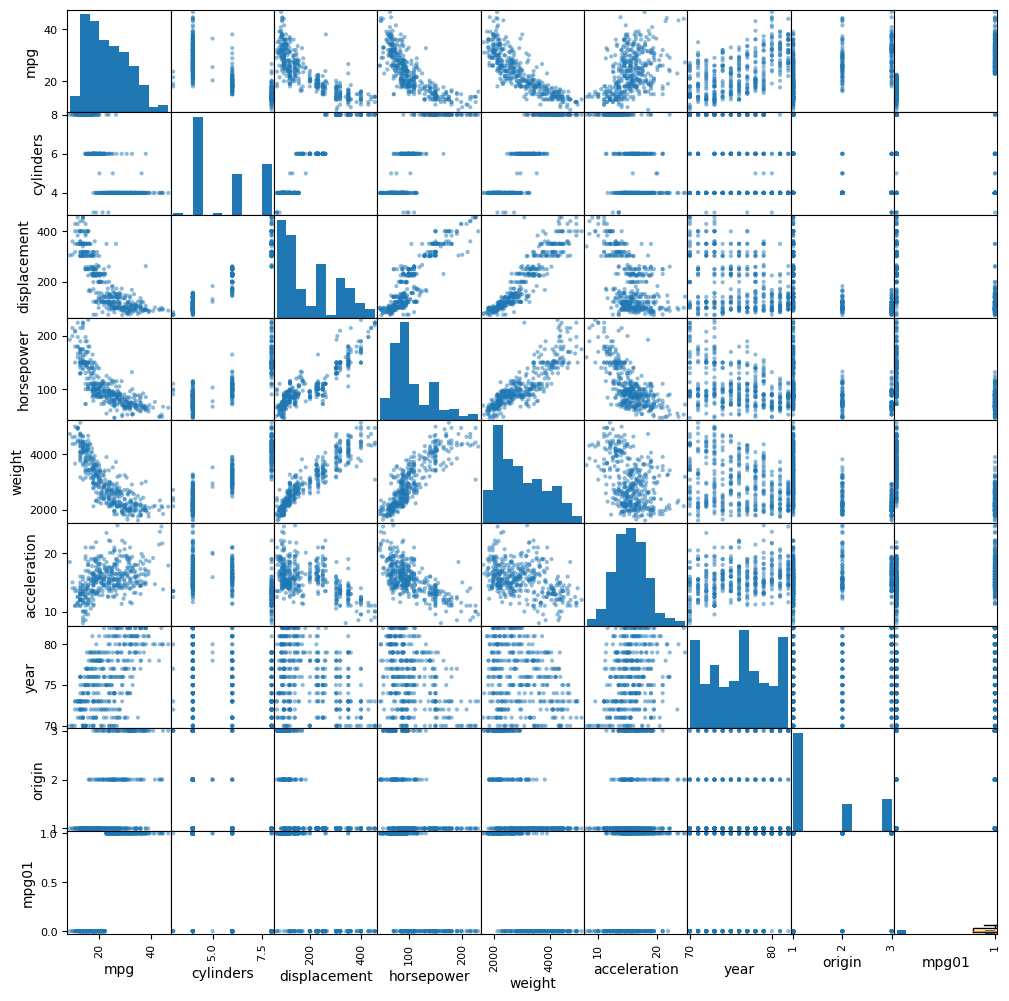

In [103]:
Auto_new = Auto.dropna()
pd.plotting.scatter_matrix(Auto_new, alpha=0.5, figsize=(12,12))

data = [Auto_new['displacement'],Auto_new['horsepower'],Auto_new['weight'],Auto_new['acceleration']]
plt.boxplot(data)

{'whiskers': [<matplotlib.lines.Line2D at 0x1cdd4f76050>,
 'caps': [<matplotlib.lines.Line2D at 0x1cdd4f75b40>,
 'boxes': [<matplotlib.lines.Line2D at 0x1cdd4f750f0>,
 'medians': [<matplotlib.lines.Line2D at 0x1cdd4f74070>,
 'fliers': [<matplotlib.lines.Line2D at 0x1cdd4f761d0>,
 'means': []}

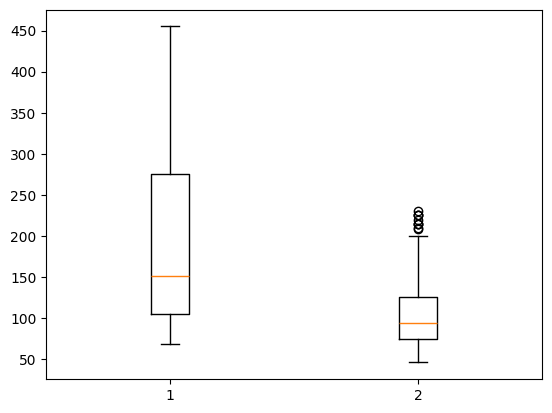

In [104]:
data = [Auto_new['displacement'],Auto_new['horsepower']]
plt.boxplot(data)

<Axes: >

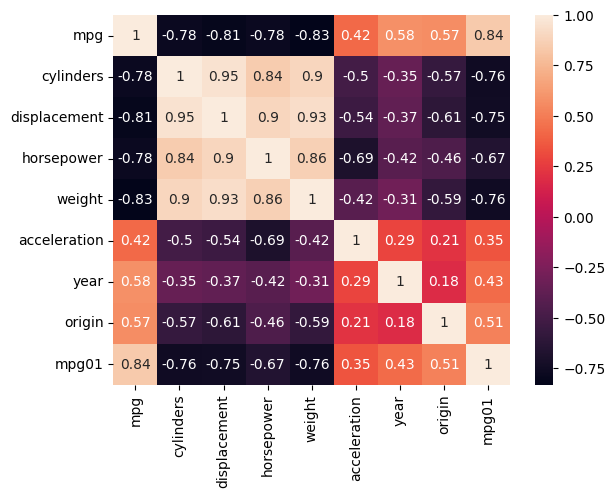

In [105]:
sns.heatmap(Auto_new.corr(),annot=True)

c.

Split the data into a training set and a test set.

In [106]:
def train_test_split1(X,y,test_size):
    val = test_size
    size = X.shape[0]
    X_train,X_test = X[:math.ceil((1-val)*size)],X[math.ceil((1-val)*size):]
    y_train,y_test = y[:math.ceil((1-val)*size)],y[math.ceil((1-val)*size):]
    return X_train, y_train, X_test, y_test

X = MS(['cylinders','displacement','acceleration']).fit_transform(Auto_new)
X = X.drop(columns='intercept')
y = Auto_new['mpg01']

X_train, y_train, X_test, y_test = train_test_split1(X,y,0.20)

In [107]:
print(Auto_new.shape[0])
print(y_train.shape[0]+y_test.shape[0])

392
392


d. 

Perform LDA on the training data in order to predict mpg01
 using the variables that seemed most associated with mpg01 in
 (b). What is the test error of the model obtained?


In [108]:
lda = LDA(store_covariance=True)
lda.fit(X_train,y_train)

lda_pred = lda.predict(X_test)
print("Test error obtained: {0}".format(100*(1-np.mean(lda_pred == y_test))),"%")

Test error obtained: 7.692307692307687 %


e. 

Perform QDA on the training data in order to predict mpg01
 using the variables that seemed most associated with mpg01 in
 (b). What is the test error of the model obtained?

In [109]:
qda = QDA(store_covariance=True)
qda.fit(X_train,y_train)

qda_pred = qda.predict(X_test)
print("Test error obtained: {0}".format(100*(1-np.mean(qda_pred == y_test))),"%")

Test error obtained: 10.256410256410254 %


f.

Perform logistic regression on the training data in order to pre
dict mpg01 using the variables that seemed most associated with
 mpg01 in (b). What is the test error of the model obtained?

In [110]:
logit = LogisticRegression()
result = logit.fit(X_train,y_train)
logit_pred = result.predict(X_test)
print("Test error obtained: {0}".format(100*(1-np.mean(logit_pred == y_test))),"%")

Test error obtained: 11.538461538461542 %


g.

Perform naive Bayes on the training data in order to predict
 mpg01 using the variables that seemed most associated with mpg01
 in (b). What is the test error of the model obtained?

In [111]:
nb = GaussianNB()
nb.fit(X_train,y_train)
nb_pred = nb.predict(X_test)
print("Test error obtained: {0}".format(100*(1-np.mean(nb_pred == y_test))),"%")

Test error obtained: 10.256410256410254 %


h.

 Perform KNN on the training data, with several values of K, in
 order to predict mpg01. Use only the variables that seemed most
 associated with mpg01 in (b). What test errors do you obtain?
 Which value of K seems to perform the best on this data set?

In [112]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1_pred = knn1.fit(X_train,y_train).predict(X_test)
print("K=1")
print("Test error obtained: {0}".format(100*(1-np.mean(knn1_pred == y_test))),"%")

K=1
Test error obtained: 25.64102564102564 %


In [113]:
knn2 = KNeighborsClassifier(n_neighbors=2)
knn2_pred = knn2.fit(X_train,y_train).predict(X_test)
print("K=2")
print("Test error obtained: {0}".format(100*(1-np.mean(knn2_pred == y_test))),"%")

K=2
Test error obtained: 29.487179487179482 %


In [114]:
knn5 = KNeighborsClassifier(n_neighbors=5)
knn5_pred = knn5.fit(X_train,y_train).predict(X_test)
print("K=5")
print("Test error obtained: {0}".format(100*(1-np.mean(knn5_pred == y_test))),"%")

K=5
Test error obtained: 21.794871794871796 %


In [115]:
knn21 = KNeighborsClassifier(n_neighbors=21)
knn21_pred = knn21.fit(X_train,y_train).predict(X_test)
print("K=21")
print("Test error obtained: {0}".format(100*(1-np.mean(knn21_pred == y_test))),"%")

K=21
Test error obtained: 3.8461538461538436 %


4.15

This problem involves writing functions.

In [116]:
import numpy as np
import matplotlib.pyplot as plt

a.

Write a function, Power(), that prints out the result of raising 2
 to the 3rd power. In other words, your function should compute
 $2^3$ and print out the results.

In [117]:
def Power():
    return print(2**3)
Power()

8


b.

Create a new function, Power2(), that allows you to pass any
 two numbers, x and a, and prints out the value of x**a. You can
 do this by beginning your function with the line
 def Power2(x, a):
 Youshould be able to call your function by entering, for instance,
 Power2(3, 8)
 on the commandline. This should output the value of $3^8$, namely,
 6,561.

In [118]:
def Power2(x,a):
    return print(x**a)
print(Power2(3,8))

6561
None


c.

Using the Power2() function that you just wrote, compute $10^3$,
 $8^{17}$, and $131^3$.

In [119]:
Power2(10,3)

1000


In [120]:
Power2(8,17)

2251799813685248


In [121]:
Power2(131,3)

2248091


d.

Now create a new function, Power3(), that actually returns the
 result $\verb|x**a|$ as a Python object, rather than simply printing it
 to the screen. That is, if you store the value $\verb|x**a|$ in an object
 called result within your function, then you can simply return return
 this result, using the following line:
 return result
 Note that the line above should be the last line in your function,
 and it should be indented 4 spaces.

In [122]:
def Power3(x,a):
    result = x**a
    return result


e.

 Now using the Power3() function, create a plot of $f(x)=x^2$.
 The x-axis should display a range of integers from 1 to 10, and
 the y-axis should display x2. Label the axes appropriately, and
 use an appropriate title for the figure. Consider displaying either
 the x-axis, the y-axis, or both on the log-scale. You can do this
 by using the ax.set_xscale() and ax.set_yscale() methods of .set_xscale()
 the axes you are plotting to.

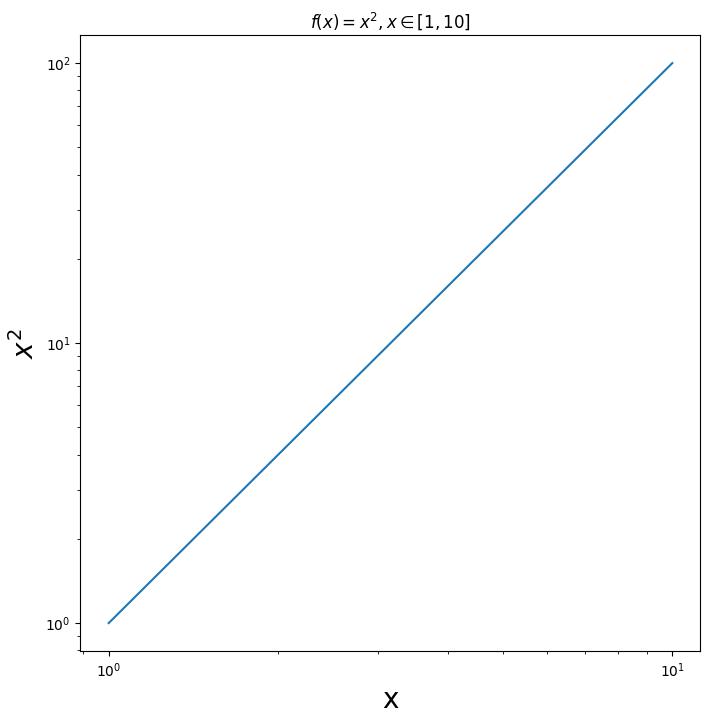

In [123]:
x = np.arange(1,10.01,0.01)
y = Power3(x,2)

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(x,y)
ax.set_ylabel('$x^2$',fontsize=20)
ax.set_xlabel('x',fontsize=20)
ax.set_title('$f(x)=x^2,x \in [1,10]$')
ax.set_xscale('log')
ax.set_yscale('log')

f.

Create a function, PlotPower(), that allows you to create a plot
 of x against x**a for a fixed a and a sequence of values of x. For
 instance, if you call
 PlotPower(np.arange(1, 11), 3)
 then a plot should be created with an x-axis taking on values
 1, 2,...,10, and a y-axis taking on values $1^3$,$2^3$,...,$10^3$

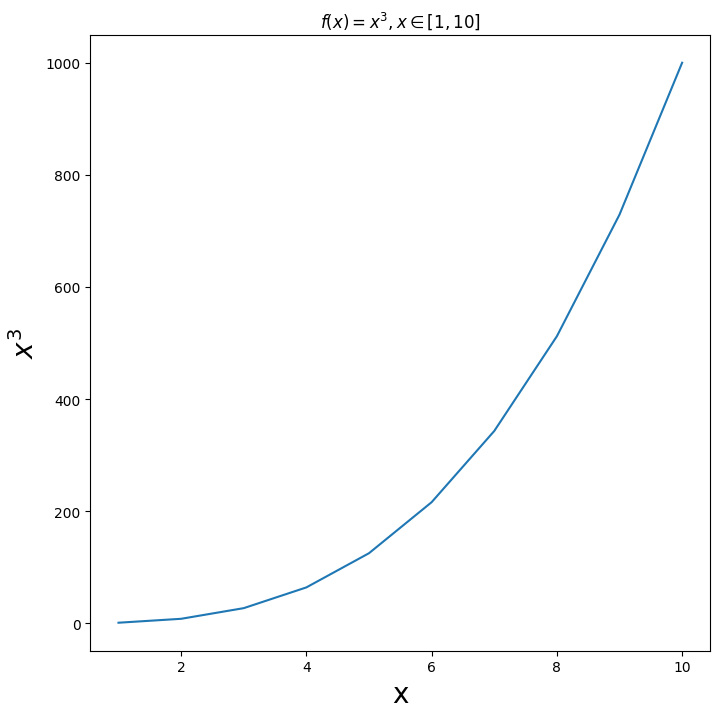

In [125]:
def PlotPower(x,a):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.plot(x,x**a)
    ax.set_ylabel('$x^{}$'.format(a),fontsize=20)
    ax.set_xlabel('x',fontsize=20)
    ax.set_title("$f(x)=x^{}".format(a) + ",x \in [{}$".format(x[0])+'$,{}]$'.format(x[len(x)-1]))
    return
    
PlotPower(np.arange(1,11),3)

4.16

Using the Boston data set, fit classification models in order to predict
 whether a given suburb has a crime rate above or below the median.
 Explore logistic regression, LDA, naive Bayes, and KNN models using
 various subsets of the predictors. Describe your findings.

$\textit{Hint: You will have to create the response variable yourself,
using the
 variables that are contained in the Boston data set.
}$

In [126]:
from ISLP import load_data
import statsmodels.api as sm
from ISLP.models import (ModelSpec as MS,summarize)
import numpy as np
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
    (LinearDiscriminantAnalysis as LDA,
    QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

Boston = load_data('Boston')
Boston

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0


array([[<Axes: xlabel='crim', ylabel='crim'>,
        <Axes: xlabel='zn', ylabel='crim'>,
        <Axes: xlabel='indus', ylabel='crim'>,
        <Axes: xlabel='chas', ylabel='crim'>,
        <Axes: xlabel='nox', ylabel='crim'>,
        <Axes: xlabel='rm', ylabel='crim'>,
        <Axes: xlabel='age', ylabel='crim'>,
        <Axes: xlabel='dis', ylabel='crim'>,
        <Axes: xlabel='rad', ylabel='crim'>,
        <Axes: xlabel='tax', ylabel='crim'>,
        <Axes: xlabel='ptratio', ylabel='crim'>,
        <Axes: xlabel='lstat', ylabel='crim'>,
        <Axes: xlabel='medv', ylabel='crim'>],
       [<Axes: xlabel='crim', ylabel='zn'>,
        <Axes: xlabel='zn', ylabel='zn'>,
        <Axes: xlabel='indus', ylabel='zn'>,
        <Axes: xlabel='chas', ylabel='zn'>,
        <Axes: xlabel='nox', ylabel='zn'>,
        <Axes: xlabel='rm', ylabel='zn'>,
        <Axes: xlabel='age', ylabel='zn'>,
        <Axes: xlabel='dis', ylabel='zn'>,
        <Axes: xlabel='rad', ylabel='zn'>,
        <Axes: x

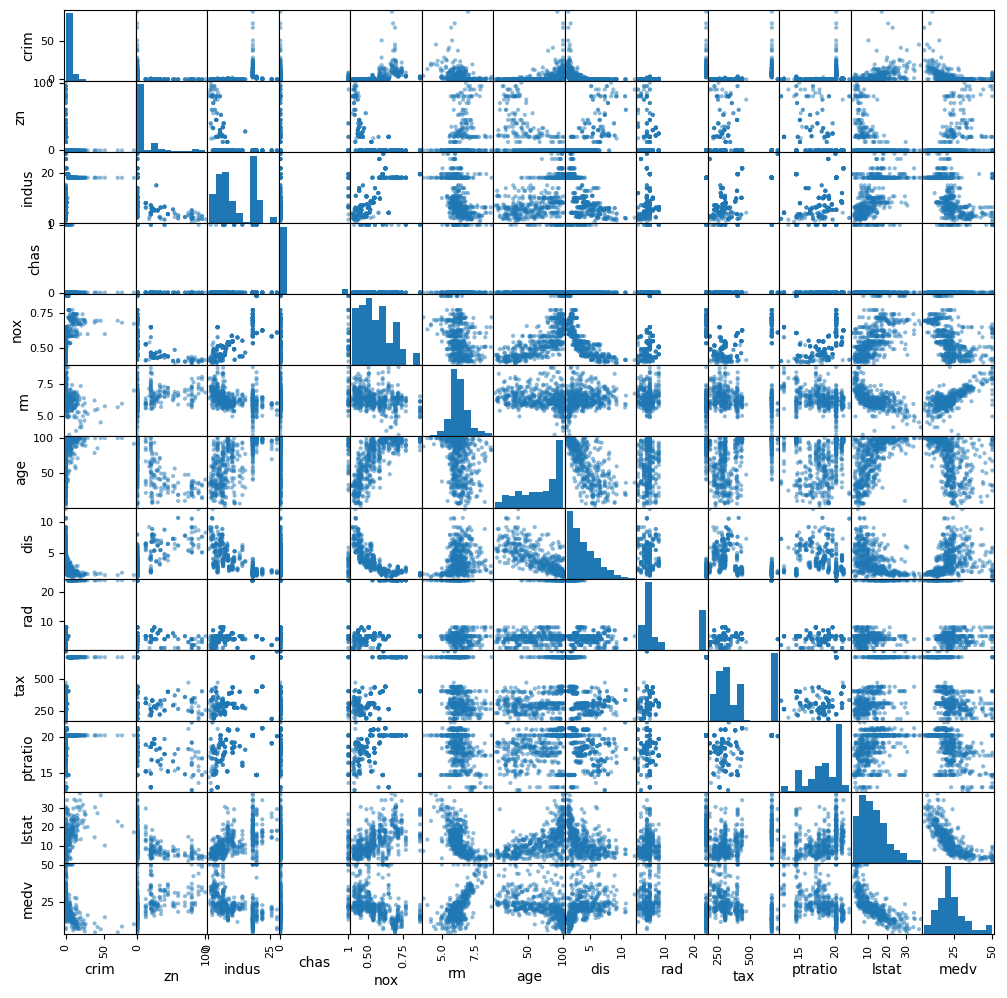

In [127]:
pd.plotting.scatter_matrix(Boston, alpha=0.5, figsize=(12,12))

<Axes: >

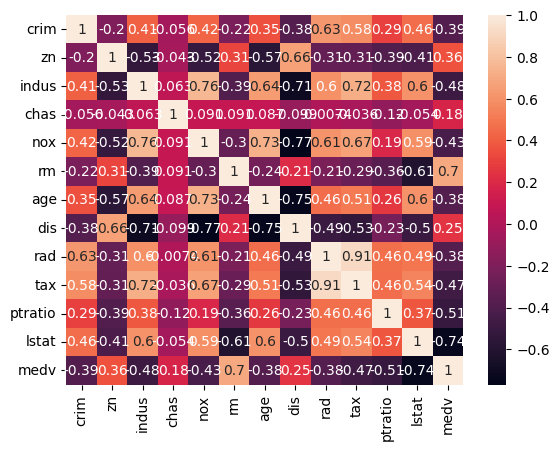

In [128]:
sns.heatmap(Boston.corr(),annot=True)

<Axes: >

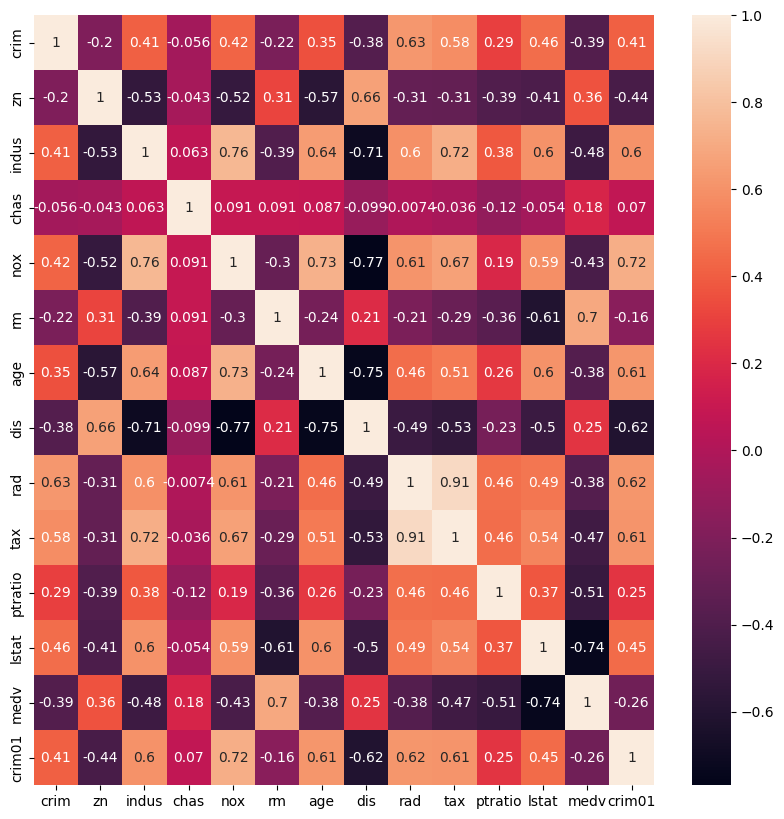

In [129]:
crim = Boston['crim']
Boston['crim01'] = np.where(crim < np.median(crim),0,1)

fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(Boston.corr(),annot=True)

In [130]:
y = Boston['crim01']
X = MS(['indus','nox','age','dis','rad','tax']).fit_transform(Boston)

In [131]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

preform the fitting methods Logistic Regression, Gaussian Naive Bayes, and KNN for $K={1,5,10}$

In [142]:
logit = LogisticRegression(max_iter=10000)
result = logit.fit(X_train,y_train)
logit_pred = result.predict(X_test)
print("Test error obtained: {0}".format(100*(1-np.mean(logit_pred == y_test))),"%")

Test error obtained: 20.588235294117652 %


In [134]:
nb = GaussianNB()
nb.fit(X_train,y_train)

nb_pred = nb.predict(X_test)
confusion_table(nb_pred,y_test)
print("Test error obtained: {0}".format(100*(1-np.mean(nb_pred == y_test))),"%")

Test error obtained: 21.568627450980394 %


In [135]:
lda = LDA(store_covariance=True)
lda.fit(X_train,y_train)

lda_pred = lda.predict(X_test)
print("Test error obtained: {0}".format(100*(1-np.mean(lda_pred == y_test))),"%")

Test error obtained: 20.588235294117652 %


In [141]:
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1_pred = knn1.fit(X_train,y_train).predict(X_test)
print("K=1")
print("Test error obtained: {0}".format(100*(1-np.mean(knn1_pred == y_test))),"%")

K=1
Test error obtained: 7.843137254901967 %


In [137]:
knn1 = KNeighborsClassifier(n_neighbors=5)
knn1_pred = knn1.fit(X_train,y_train).predict(X_test)
print("K=5")
print("Test error obtained: {0}".format(100*(1-np.mean(knn1_pred == y_test))),"%")

K=5
Test error obtained: 9.80392156862745 %


In [138]:
knn1 = KNeighborsClassifier(n_neighbors=10)
knn1_pred = knn1.fit(X_train,y_train).predict(X_test)
print("K=10")
print("Test error obtained: {0}".format(100*(1-np.mean(knn1_pred == y_test))),"%")

K=10
Test error obtained: 11.764705882352944 %


In [145]:
y = Boston['crim01']
X = MS(['indus','nox','age','dis']).fit_transform(Boston)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [146]:
logit = LogisticRegression(max_iter=10000)
result = logit.fit(X_train,y_train)
logit_pred = result.predict(X_test)
print("Test error obtained: {0}".format(100*(1-np.mean(logit_pred == y_test))),"%")

Test error obtained: 18.627450980392158 %


In [147]:
nb = GaussianNB()
nb.fit(X_train,y_train)

nb_pred = nb.predict(X_test)
confusion_table(nb_pred,y_test)
print("Test error obtained: {0}".format(100*(1-np.mean(nb_pred == y_test))),"%")

Test error obtained: 18.627450980392158 %


In [148]:
lda = LDA(store_covariance=True)
lda.fit(X_train,y_train)

lda_pred = lda.predict(X_test)
print("Test error obtained: {0}".format(100*(1-np.mean(lda_pred == y_test))),"%")

Test error obtained: 15.686274509803921 %


In [149]:
param = [1,5,10]
for i in param:
    knn1 = KNeighborsClassifier(n_neighbors=i)
    knn1_pred = knn1.fit(X_train,y_train).predict(X_test)
    print("K={0}".format(i))
    print("Test error obtained: {0}".format(100*(1-np.mean(knn1_pred == y_test))),"%")

K=1
Test error obtained: 19.6078431372549 %
K=5
Test error obtained: 20.588235294117652 %
K=10
Test error obtained: 20.588235294117652 %


Now take out three of the lowest variables that are correlated to crim01, that is indus, age and tax

In [150]:
y = Boston['crim01']
X = MS(['nox','dis','rad']).fit_transform(Boston)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [151]:
logit = LogisticRegression(max_iter=10000)
result = logit.fit(X_train,y_train)
logit_pred = result.predict(X_test)
print("Test error obtained: {0}".format(100*(1-np.mean(logit_pred == y_test))),"%")

Test error obtained: 15.686274509803921 %


In [152]:
nb = GaussianNB()
nb.fit(X_train,y_train)

nb_pred = nb.predict(X_test)
confusion_table(nb_pred,y_test)
print("Test error obtained: {0}".format(100*(1-np.mean(nb_pred == y_test))),"%")

Test error obtained: 11.764705882352944 %


In [153]:
lda = LDA(store_covariance=True)
lda.fit(X_train,y_train)

lda_pred = lda.predict(X_test)
print("Test error obtained: {0}".format(100*(1-np.mean(lda_pred == y_test))),"%")

Test error obtained: 13.725490196078427 %


In [154]:
for i in param:
    knn1 = KNeighborsClassifier(n_neighbors=i)
    knn1_pred = knn1.fit(X_train,y_train).predict(X_test)
    print("K={0}".format(i))
    print("Test error obtained: {0}".format(100*(1-np.mean(knn1_pred == y_test))),"%")

K=1
Test error obtained: 7.843137254901967 %
K=5
Test error obtained: 10.784313725490192 %
K=10
Test error obtained: 13.725490196078427 %


now testing with all selected predictors but changing the size of the test set for test size of $50%$

In [175]:
y = Boston['crim01']
X = MS(['indus','nox','age','dis','rad','tax']).fit_transform(Boston)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5)

In [176]:
logit = LogisticRegression(max_iter=10000)
result = logit.fit(X_train,y_train)
logit_pred = result.predict(X_test)
print("Test error obtained: {0}".format(100*(1-np.mean(logit_pred == y_test))),"%")

Test error obtained: 16.600790513833996 %


In [177]:
nb = GaussianNB()
nb.fit(X_train,y_train)

nb_pred = nb.predict(X_test)
confusion_table(nb_pred,y_test)
print("Test error obtained: {0}".format(100*(1-np.mean(nb_pred == y_test))),"%")

Test error obtained: 17.391304347826086 %


In [178]:
lda = LDA(store_covariance=True)
lda.fit(X_train,y_train)

lda_pred = lda.predict(X_test)
print("Test error obtained: {0}".format(100*(1-np.mean(lda_pred == y_test))),"%")

Test error obtained: 14.62450592885376 %


In [179]:
for i in param:
    knn1 = KNeighborsClassifier(n_neighbors=i)
    knn1_pred = knn1.fit(X_train,y_train).predict(X_test)
    print("K={0}".format(i))
    print("Test error obtained: {0}".format(100*(1-np.mean(knn1_pred == y_test))),"%")

K=1
Test error obtained: 8.695652173913048 %
K=5
Test error obtained: 11.067193675889332 %
K=10
Test error obtained: 11.857707509881422 %


We may conclude that KNN for $k=1$ is the best model but we may be overfitting when the nearest neighbour equals to one. Although for k=5 we can assume that we are not overfitting